In [16]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Data Loaders and Train Model

In [8]:
root = r'C:\Users\islam\Downloads\metadataset04052021\outputs'

# Defining the Models

In [57]:
in_distributions = [
    ["dog_with_water", "cat", "bird", "bear", "elephant"],
    ["dog_with_car", "cat", "bird", "bear", "elephant"],
    ["dog_with_bed", "cat", "bird", "bear", "elephant"],
    ["dog_with_snow", "cat", "bird", "bear", "elephant"],
    
    ["dog", "cat_with_bed", "bird", "bear", "elephant"],
    ["dog", "cat_with_water", "bird", "bear", "elephant"],
    ["dog", "cat_with_person", "bird", "bear", "elephant"],
    ["dog", "cat_with_television", "bird", "bear", "elephant"],
    
    ["dog", "cat", "bird_with_water", "bear", "elephant"],    
    ["dog", "cat", "bird_with_fence", "bear", "elephant"],    
    ["dog", "cat", "bird_with_sand", "bear", "elephant"],    
    
    ["dog", "cat", "bird", "bear_with_water", "elephant"],    
    ["dog", "cat", "bird", "bear_with_grass", "elephant"],    
    
    ["dog", "cat", "bird", "bear", "elephant_with_water"],    
    ["dog", "cat", "bird", "bear", "elephant_with_woman"],    
    ["dog", "cat", "bird", "bear", "elephant_with_people"],    
    
    ["dog", "cat", "bird", "bear_with_chair", "elephant"],    
    ["dog", "cat", "bird", "bear_with_ground", "elephant"],    
    ["dog", "cat", "bird", "bear", "elephant_with_ground"],    
    ["dog", "cat", "bird", "bear", "elephant_with_tree"],   
    
    ["dog_with_bag", "cat", "bird", "bear", "elephant"],
    ["dog_with_carpet", "cat", "bird", "bear", "elephant"],
    ["dog_with_grass", "cat", "bird", "bear", "elephant"],
    ["dog_with_horse", "cat", "bird", "bear", "elephant"],
    
    ["dog", "cat_with_bag", "bird", "bear", "elephant"],
    ["dog", "cat_with_carpet", "bird", "bear", "elephant"],
    ["dog", "cat_with_mirror", "bird", "bear", "elephant"],
    ["dog", "cat_with_lamp", "bird", "bear", "elephant"],    
    ["dog", "cat", "bird", "bear", "elephant"],    
    
    "--",
    ["dog", "cat", "bird_with_sky", "bear", "elephant"],    
    ["dog", "cat", "bird_with_boat", "bear", "elephant"],    
    ["dog", "cat", "bird_with_branch", "bear", "elephant"],   
    ["dog", "cat", "bird_with_chair", "bear", "elephant"],   
    ["dog", "cat", "bird_with_tree", "bear", "elephant"],   
    
]

out_distributions = [
    ["dog_with_car", "cat_with_car"],
    ["dog_with_water", "cat_with_water"],
    ["dog_with_water", "cat_with_water"],
    ["dog_with_water", "cat_with_water"],
    
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    
    ["bird_with_rock", "bear_with_rock"],
    ["bird_with_rock", "bear_with_rock"],
    ["bird_with_rock", "bear_with_rock"],

    ["bear_with_rock", "bird_with_rock"],
    ["bear_with_rock", "bird_with_rock"],

    ["elephant_with_grass", "bear_with_grass"],
    ["elephant_with_grass", "bear_with_grass"],
    ["elephant_with_grass", "bear_with_grass"],
    
    ["bear_with_rock", "bird_with_rock"],
    ["bear_with_rock", "bird_with_rock"],
    ["elephant_with_grass", "bear_with_grass"],
    ["elephant_with_grass", "bear_with_grass"],    

    ["dog_with_car", "cat_with_car"],
    ["dog_with_water", "cat_with_water"],
    ["dog_with_water", "cat_with_water"],
    ["dog_with_water", "cat_with_water"],    
    
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car"],
    ["cat_with_car", "dog_with_car", "bird_with_rock"],
    
    "--",
    ["bird_with_grass"],
    ["bird_with_grass"],
    ["bird_with_water"],
    ["bird_with_sand"],
    ["bird_with_water"],
]

assert(len(in_distributions)==len(out_distributions))

# Set up the Model

In [37]:
model_name = "squeezenet"
input_size = 224
num_classes = len(in_distributions[0])
batch_size = 8
num_epochs = 5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224
    return model_ft, input_size


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['val', 'train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} phase | Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [38]:
def delete_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def test_drift(out_of_distributions, n_drift=50):    
    accs = []
    os.makedirs(os.path.join(output_path, "drift"), exist_ok=True)

    for cls in [c.split("_")[0] for c in in_distribution]:
        os.makedirs(os.path.join(output_path, "drift", cls), exist_ok=True)

    for folder in out_of_distributions:
        cls = folder.split("_")[0]
        image_path = os.path.join(root, cls, folder)
        images = glob.glob(os.path.join(image_path, "*.jpg"), recursive=False)

        delete_folder(os.path.join(output_path, "drift", cls))
        for img in images[:n_drift]:
            shutil.copy(img, os.path.join(output_path, "drift", cls))

        drift_datasets = {'drift': datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms['val'])}
        dataloaders_drift = {'drift': torch.utils.data.DataLoader(drift_datasets['drift'], batch_size=batch_size, shuffle=True, num_workers=4)}

        # evaluate drift perfomrance
        model_ft.eval()   # Set model to evaluate mode
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in dataloaders_drift['drift']:

            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(False):
                outputs = model_ft(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)

        acc = running_corrects.double() / len(dataloaders_drift['drift'].dataset)
        print(folder, acc.numpy())
        accs.append(acc.numpy())
    return accs

# Train a Bunch of Models

In [39]:
for i in range(30, 35):
    print('Model', i)
    # Reorganize data folders 
    n_train = 160
    n_val = 40

    # The training distribution
    in_distribution = in_distributions[i]

    # Create folders for training and validation
    output_path = "experimental_data/experiments-{}".format(i)
    os.makedirs(os.path.join(output_path, "train"))
    os.makedirs(os.path.join(output_path, "val"))
    
    # Save images in the right places
    for folder in in_distribution:
        if "_" in folder:
            cls = folder.split("_")[0]
            image_path = os.path.join(root, cls, folder)
            images = glob.glob(os.path.join(image_path, "*.jpg"), recursive=False)
        else:
            cls = folder
            image_path = os.path.join(root, cls)
            images = glob.glob(os.path.join(image_path, "**/*.jpg"), recursive=True)

        random.shuffle(images)

        for img in images[:n_train]:
            os.makedirs(os.path.join(output_path, "train", cls), exist_ok=True)
            shutil.copy(img, os.path.join(output_path, "train", cls))
        for img in images[n_train:n_train+n_val]:
            os.makedirs(os.path.join(output_path, "val", cls), exist_ok=True)
            shutil.copy(img, os.path.join(output_path, "val", cls))        
    

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(output_path, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available

    print("Initialized Datasets and Dataloaders") 
    
    model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
    
    # Send the model to GPU
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()    
    
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    
    plt.figure()
    plt.plot(hist, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Validation accuracy')  
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'hist.png'))
    
    torch.save(model_ft, open("confounded-model-{}.pt".format(i), "wb"))
               
    test_drift(out_distributions[i])

Model 30


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'experimental_data/experiments-30\\train'

# Evaluation Methods

## Just Measure Drift Accuracy

In [27]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()    

for experiment_id in [len(in_distributions)-3, len(in_distributions)-5]:
    i = experiment_id
    in_distribution = in_distributions[i]
    print(experiment_id, in_distributions[experiment_id])
    output_path = "experimental_data/experiments-{}".format(experiment_id)
    model_ft = torch.load(open("confounded-model-{}.pt".format(experiment_id), "rb"))
    test_drift(out_distributions[experiment_id])

25 ['dog', 'cat_with_carpet', 'bird', 'bear', 'elephant']
cat_with_car 0.5
dog_with_car 0.5
23 ['dog_with_horse', 'cat', 'bird', 'bear', 'elephant']
dog_with_water 0.12
cat_with_water 0.34


In [29]:
def get_concept_scores(tensor, correct_idx):
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return concept_scores, concept_scores_list    

In [30]:
in_distribution = in_distributions[experiment_id]
in_distribution

['dog', 'cat', 'bird_with_boat', 'bear', 'elephant']

In [ ]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))
top_k = 3

for experiment_id in range(9, 35):    
    model_ft = torch.load(open("confounded-model-{}.pt".format(experiment_id), "rb"))
    out_distribution = out_distributions[experiment_id]
    in_distribution = in_distributions[experiment_id]
    
    for cl in in_distribution:
        if "_" in cl:
            animal = cl.split("_")[0]
            true_concept = cl.split("_")[-1]     
    if true_concept == 'branch':
        true_concept = 'tree'
    print(experiment_id, 'animal:', animal, 'concept:', true_concept)
    
    class SqueezenetBottom(nn.Module):
        def __init__(self, original_model):
            super(SqueezenetBottom, self).__init__()
            self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

        def forward(self, x):
            x = self.features(x)
            return x

    class SqueezenetTop(nn.Module):
        def __init__(self, original_model):
            super(SqueezenetTop, self).__init__()
            self.features = nn.Sequential(*list(original_model.children())[1])

        def forward(self, x):
            x = x.view((-1, 512, 13, 13))
            x = self.features(x)
            x = x.view((-1, 5))
            x = nn.Softmax(dim=-1)(x)
            return x

    def get_model_parts(model):    
        model_bottom = SqueezenetBottom(model)
        model_top = SqueezenetTop(model)
        return model_bottom, model_top

    model_bottom, model_top = get_model_parts(model_ft)
    model_bottom.eval()
    model_top.eval();

    output_path = "experimental_data/experiments-{}/".format(experiment_id)
    test_drift(out_distributions[experiment_id])
    

    drift_datasets = datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms['val'])
    dataloaders_drift = torch.utils.data.DataLoader(drift_datasets, batch_size=1, shuffle=True, num_workers=4)

    spurious_datasets = datasets.ImageFolder(os.path.join(output_path, 'train'), data_transforms['val'])
    dataloaders_spurious = torch.utils.data.DataLoader(spurious_datasets, batch_size=1, shuffle=True, num_workers=4)

    # def get_tcav_results():
    #     all_tcav_results = defaultdict(int)
    #     for inputs, labels in tqdm.tqdm(dataloaders_drift):
    #         if labels.detach().numpy()[0] == drift_datasets.class_to_idx[animal]:
    #             embeddings = model_bottom(inputs)
    #             for key in concept_dict:
    #                 coefs, _, _ = concept_dict[key]
    #                 if coefs.flatten().dot(embeddings.flatten()) > 0:
    #                     all_tcav_results[key] += 1

    #     return all_tcav_results            

    # all_random_results = defaultdict(int)
    all_class_results = []
    all_ces_results = []

    for i, (inputs, labels) in enumerate(dataloaders_drift):   
        if labels.detach().numpy()[0] == drift_datasets.class_to_idx[animal]:
            concept_scores, concept_scores_list = get_concept_scores(inputs, drift_datasets.class_to_idx[animal])
            all_ces_results.append(concept_scores_list.index(true_concept))
    for i, (inputs, labels) in enumerate(dataloaders_spurious):   
        if not(labels.detach().numpy()[0] == spurious_datasets.class_to_idx[animal]):
            concept_scores, concept_scores_list = get_concept_scores(inputs, spurious_datasets.class_to_idx[animal])
            all_class_results.append(concept_scores_list.index(true_concept))
        if len(all_class_results) > 30:
            break

    all_class_results = np.array(all_class_results)
    all_ces_results = np.array(all_ces_results)

    class_score = len(all_class_results[all_class_results < top_k]) / len(all_class_results)
    ces_score = len(all_ces_results[all_ces_results < top_k]) / len(all_ces_results)
    
#     print('all_class_results', all_class_results, class_score)
    print('all_ces_results', all_ces_results, ces_score)

    plt.figure()
    plt.bar(['Random', 'CES (Control)', 'CES'], [top_k/150, class_score, ces_score], color=['silver','gray', 'black'])
    plt.yticks(fontname='Arial', fontsize=18)
    plt.xticks(fontname='Arial', fontsize=16)
    plt.ylim([0, 1])
    plt.ylabel('Fraction of samples\n concept is in top 3', fontname='Arial', fontsize=18)
    plt.title('"{}" correlated with "{}"'.format(animal.title(), true_concept.title()), fontsize=20, fontname='Arial')

9 animal: bird concept: fence
bird_with_rock 0.79
bear_with_rock 0.79
all_ces_results [ 7  5 12  4 10 10 11 75  2 50 25  6  4  4 96  5  5  4 44 56 10 19 51 10
 42  6  3 11  4  3 82 25 17 87 14  4 53  7 14  9  5  6 13 44  3  6 77  4
 95 12] 0.02
10 animal: bird concept: sand
bird_with_rock 0.25
bear_with_rock 0.25


In [49]:
# model_ft = torch.load(open("confounded-model-{}.pt".format(28), "rb"))

# class SqueezenetBottom(nn.Module):
#     def __init__(self, original_model):
#         super(SqueezenetBottom, self).__init__()
#         self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

#     def forward(self, x):
#         x = self.features(x)
#         return x

# class SqueezenetTop(nn.Module):
#     def __init__(self, original_model):
#         super(SqueezenetTop, self).__init__()
#         self.features = nn.Sequential(*list(original_model.children())[1])

#     def forward(self, x):
#         x = x.view((-1, 512, 13, 13))
#         x = self.features(x)
#         x = x.view((-1, 5))
#         x = nn.Softmax(dim=-1)(x)
#         return x

# def get_model_parts(model):    
#     model_bottom = SqueezenetBottom(model)
#     model_top = SqueezenetTop(model)
#     return model_bottom, model_top

# model_bottom, model_top = get_model_parts(model_ft)
# model_bottom.eval()
# model_top.eval();

# drift_datasets = datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms['val'])
# dataloaders_drift = torch.utils.data.DataLoader(drift_datasets, batch_size=1, shuffle=True, num_workers=4)

# all_ces_results = []

# for i, (inputs, labels) in enumerate(dataloaders_drift):   
#     if labels.detach().numpy()[0] == drift_datasets.class_to_idx[animal]:
#         concept_scores, concept_scores_list = get_concept_scores(inputs, drift_datasets.class_to_idx[animal])
#         all_ces_results.append(concept_scores_list.index(true_concept))

all_ces_results = np.array(all_ces_results)
ces_score = len(all_ces_results[all_ces_results < top_k]) / len(all_ces_results)
print('all_ces_results', all_ces_results, ces_score)

all_ces_results [ 49  31  54 104  11  19  20   8   8  90   7   3  57  42   1   3  70  32
   1  55   2  33   9   9  20  47  52   3  10   7   8   2  16   7   6  13
  32   7  10  12   2  51   8  43   5  13   6  41   4   6] 0.1


Text(0.5, 1.0, '"Bird" correlated with "Boat"')

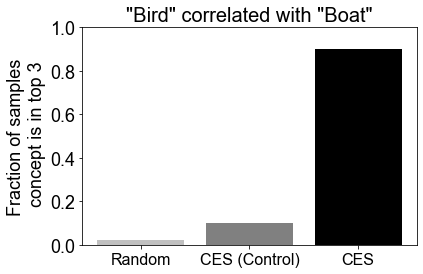

In [51]:
plt.figure()
plt.bar(['Random', 'CES (Control)', 'CES'], [top_k/150, 0.1,0.9], color=['silver','gray', 'black'])
plt.yticks(fontname='Arial', fontsize=18)
plt.xticks(fontname='Arial', fontsize=16)
plt.ylim([0, 1])
plt.ylabel('Fraction of samples\n concept is in top 3', fontname='Arial', fontsize=18)
plt.title('"{}" correlated with "{}"'.format(animal.title(), "Boat".title()), fontsize=20, fontname='Arial')

In [272]:
def get_concept_scores(tensors, correct_idx):
    concept_scores = {}
    embeddings = model_bottom(tensors)
    original_preds = model_top(embeddings).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embeddings.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus).detach().numpy().squeeze()
        plus_diff = plus_preds.squeeze()[:, correct_idx] - original_preds.squeeze()[:, correct_idx]
        concept_scores[key] = float(np.mean(plus_diff))
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return concept_scores, concept_scores_list    

In [274]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))
top_k = 3

for experiment_id in [23, 25]:
    for batch_size in [2, 5, 10, 25]:
        
        model_ft = torch.load(open("confounded-model-{}.pt".format(experiment_id), "rb"))
        class SqueezenetBottom(nn.Module):
            def __init__(self, original_model):
                super(SqueezenetBottom, self).__init__()
                self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

            def forward(self, x):
                x = self.features(x)
                return x

        class SqueezenetTop(nn.Module):
            def __init__(self, original_model):
                super(SqueezenetTop, self).__init__()
                self.features = nn.Sequential(*list(original_model.children())[1])

            def forward(self, x):
                x = x.view((-1, 512, 13, 13))
                x = self.features(x)
                x = x.view((-1, 5))
                x = nn.Softmax(dim=-1)(x)
                return x

        def get_model_parts(model):    
            model_bottom = SqueezenetBottom(model)
            model_top = SqueezenetTop(model)
            return model_bottom, model_top

        model_bottom, model_top = get_model_parts(model_ft)
        model_bottom.eval()
        model_top.eval();

        out_distribution = out_distributions[experiment_id]
        in_distribution = in_distributions[experiment_id]
        correlation = [term for term in in_distribution if "with" in term][0]
        animal = correlation.split('_')[0]
        true_concept = correlation.split('_')[-1]
        print(experiment_id, 'correlation:', correlation, 'concept:', true_concept)

        output_path = "experimental_data/experiments-{}/".format(experiment_id)
        drift_datasets = datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms['val'])
        dataloaders_drift = torch.utils.data.DataLoader(drift_datasets, batch_size=batch_size, shuffle=True, num_workers=4)

        all_ces_results = []

        for i, (inputs, labels) in enumerate(dataloaders_drift):   
            concept_scores, concept_scores_list = get_concept_scores(inputs, drift_datasets.class_to_idx[animal])
            all_ces_results.append(concept_scores_list.index(true_concept))

        all_ces_results = np.array(all_ces_results)

        ces_score = len(all_ces_results[all_ces_results < top_k]) / len(all_ces_results)

        print(experiment_id, batch_size, 'all_ces_results', all_ces_results, ces_score)

23 correlation: dog_with_horse concept: horse
23 2 all_ces_results [3 1 1 0 0 0 8 2 1 0 3 0 3 1 3 1 5 1 1 4 1 5 3 1 0] 0.64
23 correlation: dog_with_horse concept: horse
23 5 all_ces_results [0 1 0 1 0 0 1 0 3 1] 0.9
23 correlation: dog_with_horse concept: horse
23 10 all_ces_results [0 1 0 0 0] 1.0
23 correlation: dog_with_horse concept: horse
23 25 all_ces_results [0 0] 1.0
25 correlation: cat_with_carpet concept: carpet
25 2 all_ces_results [12  6  2  2  5  5  7  4  4  4 49  3  7  5  4  0  2  7  5  8 13  5  5  1
  1  3 30  6  2  2  3  0  5  4  6  5  5  2  6  5 13  7 63  5  3  1 13  3
  3  1] 0.24
25 correlation: cat_with_carpet concept: carpet
25 5 all_ces_results [4 4 3 2 4 4 7 4 5 3 4 5 5 4 4 4 3 5 5 4] 0.05
25 correlation: cat_with_carpet concept: carpet
25 10 all_ces_results [5 5 4 4 4 4 4 3 5 4] 0.0
25 correlation: cat_with_carpet concept: carpet
25 25 all_ces_results [4 4 4 4] 0.0


In [289]:
top_k = 3

for experiment_id in [25]:
    for batch_size in [2, 5, 10, 25]:
        
        model_ft = torch.load(open("confounded-model-{}.pt".format(experiment_id), "rb"))
        class SqueezenetBottom(nn.Module):
            def __init__(self, original_model):
                super(SqueezenetBottom, self).__init__()
                self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

            def forward(self, x):
                x = self.features(x)
                return x

        class SqueezenetTop(nn.Module):
            def __init__(self, original_model):
                super(SqueezenetTop, self).__init__()
                self.features = nn.Sequential(*list(original_model.children())[1])

            def forward(self, x):
                x = x.view((-1, 512, 13, 13))
                x = self.features(x)
                x = x.view((-1, 5))
                x = nn.Softmax(dim=-1)(x)
                return x

        def get_model_parts(model):    
            model_bottom = SqueezenetBottom(model)
            model_top = SqueezenetTop(model)
            return model_bottom, model_top

        model_bottom, model_top = get_model_parts(model_ft)
        model_bottom.eval()
        model_top.eval();

        out_distribution = out_distributions[experiment_id]
        in_distribution = in_distributions[experiment_id]
        correlation = [term for term in in_distribution if "with" in term][0]
        animal = correlation.split('_')[0]
        true_concept = correlation.split('_')[-1]
        print(experiment_id, 'correlation:', correlation, 'concept:', true_concept)

        output_path = "experimental_data/experiments-{}/".format(experiment_id)
        drift_datasets = datasets.ImageFolder(os.path.join(output_path, 'drift'), data_transforms['val'])
        dataloaders_drift = torch.utils.data.DataLoader(drift_datasets, batch_size=batch_size, shuffle=True, num_workers=4)

        all_ces_results = []

        for i, (inputs, labels) in enumerate(dataloaders_drift):   
            concept_scores, concept_scores_list = get_concept_scores(inputs, drift_datasets.class_to_idx[animal])
            all_ces_results.append(concept_scores_list.index(true_concept))

        all_ces_results = np.array(all_ces_results)

        ces_score = len(all_ces_results[all_ces_results < top_k]) / len(all_ces_results)

        print(experiment_id, batch_size, 'all_ces_results', all_ces_results, ces_score)

25 correlation: cat_with_carpet concept: carpet
25 2 all_ces_results [ 1  2  0  2  9  0  2  3 11  2  2  1  1 33  1  2  1  2  0 11  2  3  1 22
  9] 0.68
25 correlation: cat_with_carpet concept: carpet
25 5 all_ces_results [1 2 1 2 4 0 2 3 1 1] 0.8
25 correlation: cat_with_carpet concept: carpet
25 10 all_ces_results [2 1 1 2 1] 1.0
25 correlation: cat_with_carpet concept: carpet
25 25 all_ces_results [1 2] 1.0


Text(0.5, 0, 'Number of samples in group')

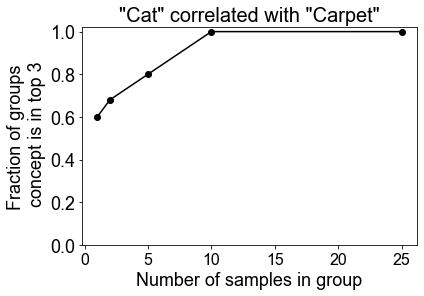

In [310]:
plt.plot([1, 2, 5, 10, 25], [0.6, 0.68, 0.8, 1.0, 1.0], 'k-o')
plt.ylim([0, 1.02])
plt.title('"{}" correlated with "{}"'.format('Cat', 'Carpet'), fontsize=20, fontname='Arial')
plt.yticks(fontname='Arial', fontsize=18)
plt.xticks(fontname='Arial', fontsize=16)
plt.ylabel('Fraction of groups\n concept is in top 3', fontname='Arial', fontsize=18)
plt.xlabel('Number of samples in group', fontname='Arial', fontsize=18)

Text(0.5, 0, 'Number of samples in group')

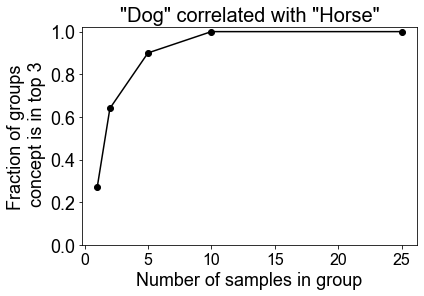

In [309]:
plt.plot([1, 2, 5, 10, 25], [0.27, 0.64, 0.9, 1.0, 1.0], 'k-o')
plt.ylim([0, 1.02])
plt.title('"{}" correlated with "{}"'.format('Dog', 'Horse'), fontsize=20, fontname='Arial')
plt.yticks(fontname='Arial', fontsize=18)
plt.xticks(fontname='Arial', fontsize=16)
plt.ylabel('Fraction of groups\n concept is in top 3', fontname='Arial', fontsize=18)
plt.xlabel('Number of samples in group', fontname='Arial', fontsize=18)